In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

# Image Classification

## Learning Goals

- Learn how to model an image classification task
- Learn how to systematically implement data prep, model architecture, training-loop, and evaluation
- Learn how to incroporate pre-trained models
- Learn how to incorporate boilerplate code from [torchvision](https://pytorch.org/vision/0.9/index.html) and  [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/)

## Setup

Let's define paths, install & load the necessary Python packages.

**Optional: Save the notebook to your personal google drive to persist changes.**

**Optional: Change runtime to a GPU instance (if using Google Colab)** 

Mount your google drive to store data and results (if running the code in Google Colab).

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

**Modify the following paths if necessary.**

That is where your data will be stored.

In [11]:
from pathlib import Path

if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/bveri")
else:
    DATA_PATH = Path("./../../workspace/code/data")

Install the package `dl_cv_lectures`.

The following code installs the package from a local repository (if available), otherwise it installs it from the exercise repository.

In [5]:
try:
    import dl_cv_lectures

    print("dl_cv_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install .")
    else:
        print("Installing from git repo")
        os.system("pip install git+https://github.com/i4Ds/bveri-exercises-hs2024")

dl_cv_lectures installed, all good


Load all packages

In [6]:
import math
import os
import random
from typing import Callable

import lightning as L
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torchshow as ts
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

import dl_cv_lectures

Define a default device for your computations.

**GPU is strongly recommended!** (otherwise the images have to be restricted in size).

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"torchvision version: {torchvision.__version__}")

Using: cuda
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
CUDA available: True
torchvision version: 0.20.1+cu121


## 1) Project Selection

Choose one of the following projects to work on. 

All datasets are structured similarily in class-specific image folders.

This notebook was thoroughly tested with the cats vs dogs dataset and uses this one as an example. 

**Choose Cats vs Dogs if you want to mainly click through the notebook.**

All other datasets require some (minor!) adaptations. Feel free to choose whichever interests you most.

### Cats vs Dogs

**Goal**: Develop a model to classify images of cats and dogs. The dataset is designed to facilitate the identification of these animals from images.

**Approach**: Create a Convolutional Neural Network (CNN) to classify the images into two categories: cats and dogs. Experiment with various CNN architectures and techniques to determine the most effective method. Use data augmentation techniques to handle variations in pose, lighting, and background. Ensure the model generalizes well by using cross-validation and monitoring for overfitting.

**Dataset**: The dataset contains 25,000 images, with approximately 12,500 images per class (cats and dogs). Each image varies in size and resolution. The data is provided by Microsoft as part of their Kaggle competition.

[Source](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

![Dog](dog.jpg)
![Cat](cat.jpg)


### Concrete Crack Detection

**Goal**: Develop a model to classify concrete images as having cracks or not. The dataset is designed to facilitate the identification of structural issues in concrete buildings.

**Approach**: Create a Convolutional Neural Network (CNN) to classify the images into negative (no crack) and positive (crack) categories. Experiment with various CNN architectures and techniques to determine the most effective method. Use image processing techniques to handle variations in surface finish and illumination. Ensure the model generalizes well by using cross-validation and monitoring for overfitting.

**Dataset**: The dataset contains 40,000 images, with 20,000 images per class (negative and positive). Each image is 227 x 227 pixels with RGB channels. The data is collected from 458 high-resolution images (4032 x 3024 pixels) from various METU Campus Buildings. No data augmentation such as random rotation or flipping is applied.

[Source](https://data.mendeley.com/datasets/5y9wdsg2zt/2)

![Crack](crack_example.jpg)
![No Crack](crack_negative.jpg)


### Scene Classification

**Goal**: Develop a model to classify natural scene images into one of six categories. The dataset aims to facilitate the recognition of various natural scenes from around the world.

**Approach**: Design a Convolutional Neural Network (CNN) to classify images into six categories: buildings, forest, glacier, mountain, sea, and street. Test different CNN architectures to find the best performing model. Apply data augmentation techniques to improve generalization. Separate the data into training, testing, and prediction sets to evaluate model performance effectively.

**Dataset**: The dataset contains around 25,000 images of size 150 x 150 pixels, distributed across six categories. The data is separated into training (14,000 images), testing (3,000 images), and prediction (7,000 images) sets.

[Source](https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download)


![Builings](natural_scenes_buildings.jpg)
![Forest](natural_scenes_forest.jpg)
![Glacier](natural_scenes_glacier.jpg)

### Choose your own dataset!

Feel free to choose your own dataset.

If you do so. It is best to organzie the data in image folders like this:

```
dataset/
├── class1/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
├── class2/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
└── ...
```
If you don't have train/val folders this is fine. The separation can be made later.


### Download the Data

Specify the dataset that you want to use and download it (unless you are using your own - in that case place it in your data directory).

**Download and extraction may take a few minutes.**

In [12]:
from dl_cv_lectures.data import (
    cats_vs_dogs,
    concrete_cracks,
    eurosat,
    scene_classification,
)

scene_classification.download(DATA_PATH)

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '..\\..\\workspace\\code\\data'

## 2) Overall Approach


### 1) Data Preparation & Data Inspection

- Download the data
- Inspect the data formats
- Build a `torch.utils.data.Dataset`
    - define training, validation and test sets
- Implement a `torch.utils.data.DataLoader'
- Inspect the data:
    - Look at samples
    - Inspect the label distribution

### 2) Implement Baselines

- Implement a small CNN
- Overfitt CNN on one batch
- Inspect pre-processing
  
### 3) Train a large model
- Use a pre-trained model and train it on your task
  
### 4) Regularize
- Is it beneficial to collect more data?
- Data Augmentation
- Early Stopping on Validation Set
- Weight Decay

## Step 1) - Data Preparation & Data Inspection

- Inspect the data formats and file organization
- Remove corrupt data
- Build a [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
    - define training, validation and test sets
- Implement a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- Inspect the data:
    - Look at samples
    - Inspect the label distribution


Important information about how to define a dataset can be found here: [https://pytorch.org/docs/stable/data.htm](https://pytorch.org/docs/stable/data.htm)

### Inspect Data Format & Organization

We need to figure out how the data is organized. Particularly, how the data is labelled, to correctly define it with a [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

First you should look at the data / folder structure of the downloaded data.

(this example command only works on Linux)


In [9]:
path = f"./{DATA_PATH}/scene_classification/intel_natural_scences_classification"
root = Path(path)


def display_folder_structure(path, indent=0):
    """
    Recursively display folder structure starting from the given path.

    Args:
        path (Path): The root directory to start from.
        indent (int): Indentation level (for recursive calls).
    """
    root = Path(path)
    if not root.exists():
        print(f"Path {path} does not exist.")
        return

    print("  " * indent + f"[{root.name}]")
    for item in root.iterdir():
        if item.is_dir():
            display_folder_structure(item, indent + 1)  # Recurse into subdirectory
            print(" " * (indent + 1) + item.name)


display_folder_structure(root)

[intel_natural_scences_classification]
  [seg_pred]
    [seg_pred]
  seg_pred
 seg_pred
  [seg_test]
    [seg_test]
      [buildings]
   buildings
      [forest]
   forest
      [glacier]
   glacier
      [mountain]
   mountain
      [sea]
   sea
      [street]
   street
  seg_test
 seg_test
  [seg_train]
    [seg_train]
      [buildings]
   buildings
      [forest]
   forest
      [glacier]
   glacier
      [mountain]
   mountain
      [sea]
   sea
      [street]
   street
  seg_train
 seg_train


It seems the data is neatly organized in class-specific folders.

In [44]:
!dir /b /s f"C:{DATA_PATH}/scene_classification/intel_natural_scences_classification" | findstr /r /c:".*" | more /T 10

Invalid parameter - /T


The system cannot find the path specified.


Seems like we have ".jpg" files. This needs to be verified further.

**Note**: You might want to check for corrupt files since they disrupt further processes. You could read each file using `PIL.Image.open` to find any errors.

We use a function to provide an inventory of all the files, along with their labels.

Change the path accordingly if you used a different dataset.

In [10]:
from dl_cv_lectures.utils import find_all_imges_and_their_labels

image_root_path = DATA_PATH.joinpath(
    "scene_classification/intel_natural_scences_classification/seg_train/seg_train"
)

observations = find_all_imges_and_their_labels(image_root_path)
len(observations)

14034

**Task**: How many images are there?

### Define a Dataset class

Once you have figured out how the data is organized we can build a [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). 

In this case we can build a map-style dataset that allows for random-access and implements `__getitem__`. We subclass `torch.utils.data.Dataset`.

**Note**: Note the option to use a `transform` function that is being applied to each image. This is going to be important!

In [11]:
from dl_cv_lectures.utils import find_all_imges_and_their_labels


class ImageFolder(Dataset):
    """Create Dataset from class specific folders."""

    def __init__(
        self,
        root_path: str | Path,
        transform: Callable | None = None,
    ):
        """
        Args:
            root_path: Path to directory that contains the class-specific folders
            transform: Optional transform to be applied on an image
            classes: List of class names.
        """
        self.root_path = root_path
        self.observations = find_all_imges_and_their_labels(root_path)
        self.transform = transform
        self.classes = sorted({x["label"] for x in self.observations})
        print(
            f"Found the following classes: {self.classes}, in total {len(self.observations)} images"
        )

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx: int):
        image_path = self.observations[idx]["image_path"]
        image = Image.open(image_path)
        label = self.observations[idx]["label"]
        label_num = self.classes.index(label)

        if self.transform:
            image = self.transform(image)
        return {"image": image, "label": label_num}

    @classmethod
    def from_subset(
        cls,
        original_dataset,
        subset_indices: list[int],
        transform: Callable | None = None,
    ):
        """
        Create a subset of the original dataset with only the specified indices.

        Args:
            original_dataset (ImageFolder): An instance of the ImageFolder dataset.
            subset_indices (List[int]): List of indices to create a subset of observations.
            transform: Override transform of current ds

        Returns:
            ImageFolder: A new instance of ImageFolder with the subset observations.
        """
        # Create a new instance with the same properties as the original
        subset_instance = cls(
            root_path=original_dataset.root_path,
            transform=original_dataset.transform if transform is None else transform,
        )

        # Filter the observations based on the subset indices
        subset_instance.observations = [
            original_dataset.observations[i] for i in subset_indices
        ]
        subset_instance.classes = original_dataset.classes  # Keep class list consistent

        print(
            f"Created a subset with {len(subset_instance.observations)} images "
            f"from the original dataset of {len(original_dataset.observations)} images"
        )

        return subset_instance


class PredictionFolder(Dataset):
    "Create class for prediction Folders"

    def __init__(
        self,
        root_path: Path,
        root_path_name: str,
        transform: Callable | None = None,
    ):
        """
        Args:
            root_path: Path to directory that contains the class-specific folders
            transform: Optional transform to be applied on an image
            classes: List of class names.
        """
        self.root_path = root_path
        self.observations = [f"{root_path_name}/{f.name}" for f in root_path.iterdir()]
        self.transform = transform
        print(f"Found in total {len(self.observations)} images in the prediction set")

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx: int):
        image_path = self.observations[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        return {"image": image}

**Question**: What is the role of: `label_num = self.classes.index(label)`?

Now we create the dataset object and inspect the first observation.

Found the following classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], in total 14034 images


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150>,
 'label': 0}

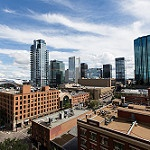

In [12]:
ds = ImageFolder(image_root_path)
ds.classes
ds[1]
ds[1]["image"]

### Create Train / Test Splits

We create train (validation) and test splits early, before we look at the data in more detail. This avoids any biases and insights that we might clean from the test set. We should set this part of the data aside and look at it only for a final model evaluation.

We use a function from `sklearn.model_selection`.

We balance the labels by using the `stratify` option.

**Note**: Some datasets may have a pre-defined split. If so, the images might be in separate test/train folders. If that is the case simply create different dataset objects.

In [13]:
root_path = f"{DATA_PATH}/scene_classification/intel_natural_scences_classification"
root_train = f"{root_path}/seg_train/seg_train"
root_test = f"{root_path}/seg_test/seg_test"
root_pred = f"{root_path}/seg_pred/seg_pred"

# read the prediction image folder
root_pred_path = Path(root_pred)
ds_train = ImageFolder(root_train)
ds_test = ImageFolder(root_test)
ds_pred = PredictionFolder(root_path=root_pred_path, root_path_name=root_pred)

Found the following classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], in total 14034 images
Found the following classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], in total 3000 images
Found in total 7301 images in the prediction set


**Question**: Why do we need a training, validation and a testset?

Now we test the `Dataset` object by getting and visualising a sample.

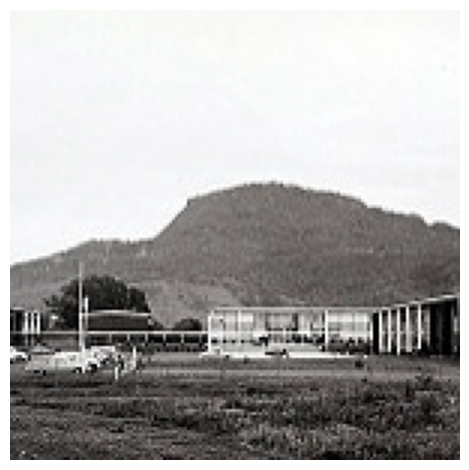

In [14]:
observation = ds_train[0]
ts.show(observation["image"])

### Create Data Loaders

For model training we need to batch examples. Thats why we need to define a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Let's see how our data is being batched, after all each observation is a dictionary.

In [15]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)

try:
    observations = next(iter(dl_train))
except TypeError as e:
    print(f"Error occurred: {e}")
    print(type(ds_train[0]["image"]))

Error occurred: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'PIL.JpegImagePlugin.JpegImageFile'>


**Oops that did not go well!**: What did we miss?

In [16]:
tr_train = transforms.Compose([transforms.v2.RGB(), transforms.ToTensor()])

ds_train = ImageFolder(root_train, transform=tr_train)
ds_val = ImageFolder(root_test, transform=tr_train)
ds_test = PredictionFolder(
    root_path=root_pred_path, root_path_name=root_pred, transform=tr_train
)

dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)

try:
    observations = next(iter(dl_train))
except (RuntimeError, TypeError) as e:
    print(f"Error occurred: {e}")

Found the following classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], in total 14034 images
Found the following classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], in total 3000 images
Found in total 7301 images in the prediction set


**Oops that did not go well!**: What did we miss?

**Question**: How does the DataLoader batch the data?

### Inspect the Data

Now you can use the `ImageDataset` or `DataLoader` objects to insepct the dataset. 

**Note**: We use only the training dataset to inspect the data.

- **Initial Step**: Avoid touching neural net code initially; focus on inspecting the data thoroughly.
- **Time Investment**: Spend hours scanning thousands of examples to understand their distribution and look for patterns.
- **Identify Issues**: Look for duplicate examples, corrupted images/labels, data imbalances, and biases.
- **Classify Process**: Pay attention to how you classify the data to inform the architecture exploration.
- **Feature Analysis**: Determine if local features or global context is needed.
- **Variation Analysis**: Assess the variation in the data, identify spurious variations for preprocessing.
- **Spatial Consideration**: Evaluate if spatial position matters or if averaging it out is beneficial.
- **Detail and Downsampling**: Consider the importance of detail and the feasibility of downsampling images.
- **Label Noise**: Assess the noise level in the labels.
- **Understand Predictions**: Use network (mis)predictions to understand inconsistencies and data issues (at a later stage!).
- **Quantitative Analysis**: Write simple code to search, filter, and sort data by various attributes.
- **Visualize Distributions**: Visualize distributions and outliers to uncover bugs in data quality or preprocessing.

For now do at least the following:
- what is the class distribution?
- how difficult do you think is the problem?
- are there any obvious issues with the data?
- do the labels seem accurate?

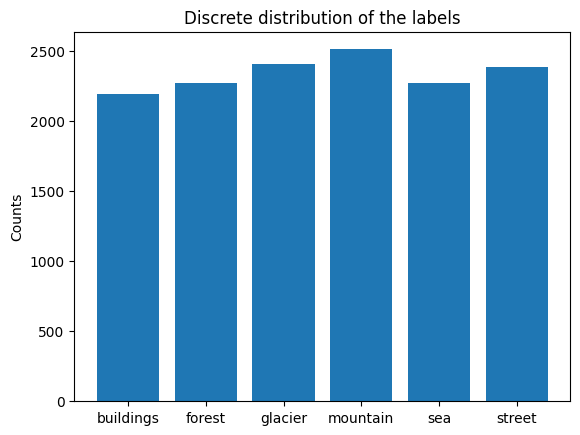

In [17]:
label, counts = np.unique(
    [obs["label"] for obs in ds_train.observations], return_counts=True
)

plt.title("Discrete distribution of the labels")
plt.ylabel("Counts")
plt.bar(label, counts)
plt.show();

**Task**: Use functions to visualize and inspect the data.

## Step 2 - Implement Baselines

In this step we want to implement a training pipeline and evaluate simple baselines to get a feeling for the problem and to test and verify if the pipeline works.

**Reproducibility**

- Fix random seed: Always use a fixed random seed to ensure consistent outcomes in repeated runs.

**Simplification and Initialization**

- Simplify: Disable unnecessary features like data augmentation initially.
- Verify loss at initialization: Ensure loss starts at the expected value.

**Baselines and Metrics**

- Human baseline: Compare model metrics to human-interpretable metrics (e.g., accuracy).
- Input-independent baseline: Train a baseline model with zeroed inputs and compare it to a variant with normal data. There should be a clear difference!

**Overfitting and Visualization**

- Overfit one batch: Overfit a single batch to verify the model can reach the minimum loss.
- Verify decreasing training loss: Ensure training loss decreases when model capacity increases.
- Visualize before the net: Visualize data immediately before feeding it to the network to catch preprocessing issues.
- Visualize prediction dynamics: Track model predictions on a fixed test batch during training to understand training progression.

**Evaluation**

- Add significant digits to your eval: Evaluate on the entire test set for accuracy.
- Visualize: Visualize model inputs and outputs to ensure correctness.

**Additional Tips**

- Verify simplifications: Simplify initial setup by turning off data augmentation and complex features to reduce bugs.

We will address some of the steps above. Feel free to do more!

### Reproducibility

The `lightning`package provides a function to set random seeds of different modules:

In [18]:
import lightning as L

L.seed_everything(123)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

### Simple DataLoader

Implement a simple dataloader without fancy transformations. To specify transformations, use [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html).

In [23]:
# Define a simple transformation
tr_train = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

ds_train = ImageFolder(root_train, transform=tr_train)
dl_train = DataLoader(ds_train, batch_size=8, shuffle=True, num_workers=3)

Found the following classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], in total 14034 images


Verify it.

In [ ]:
obs = next(iter(dl_train))
ts.show(obs["image"])
obs["image"].max()
obs["image"].min()

### Simple Model

Start with a simple model that is (most likely) correct and should be able to learn something (quickly).

Implement the following architecture:

- Convolution: 16 Filters, Kernel-Size 5x5
- Pooling: Stride 2, Kernel-Size 2
- Convolution: 32 Filter, Kernel-Size 5x5
- Global Average Pooling
- FC: 2 with **number of classes** neurons

Use `ReLU` activation after each convolution.

Define a class which inherits from `torch.nn.Module`.


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, (5, 5))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 6)  # adapt to the number of classes here

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.fc(x)
        return x


net = SmallCNN()

print(net)
print(torchinfo.summary(net, input_size=(1, 3, 32, 32)))

**Question**: Briefly explain what happens with a data point during the forward pass.

### Define a training Loop

We use Lightning which greatly simplifys implementing boilerplate code such as  training loops.

Tutorial here: https://lightning.ai/pages/community/tutorial/step-by-step-walk-through-of-pytorch-lightning/

We also include additional metrics from [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/) to easily log and calculate accuracy.  Adapt `task="binary"` if necessary!

**Note**: Calculating the metrics incorrectly is a common source of errors. Make sure to correctly aggregate metrics across an epoch.

In [ ]:
import torchmetrics


class Classifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy(
            task="binary"
        )  # Adjust task if you have more than two classes
        self.train_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update accuracy metric
        self.train_accuracy(preds, y)
        self.train_loss(loss)

        self.log("train/acc_step", self.train_accuracy, prog_bar=True)
        self.log("train/loss_step", self.train_loss, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        # log epoch metric
        self.log("train/acc_epoch", self.train_accuracy)
        self.log("train/loss_epoch", self.train_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

Change the following parameters accoring to your hardware if you need. As you can see, this simplifies hardware switches greatly!

We want to perform a functional check only. Train the model only for 10 steps.

In [ ]:
L.seed_everything(123)

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    enable_checkpointing=False,
    logger=False,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
)

dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=5)

net = SmallCNN()
model = Classifier(net)
trainer.fit(model, train_dataloaders=dl_train)

In [ ]:
trainer.logged_metrics

**Question**: What is the loss at initialization / after 10 steps? Does the value make sense?

Now we train the model for longer to get a sense of the performance (increase the number of steps `max_steps` the model is training for).

In [ ]:
L.seed_everything(123)

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    enable_checkpointing=False,
    logger=False,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
)

net = SmallCNN()
model = Classifier(net)
trainer.fit(model, train_dataloaders=dl_train)

In [ ]:
trainer.logged_metrics

**Question**: What is your conclusion? Does learning take place?

### Overfit on one Batch of Data

We train the model with only one batch. This means the model only ever sees the same `batch_size` number of images.

You might want to increase `max_steps`.

**Question**: What do you expect?

In [ ]:
L.seed_everything(123)

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    enable_checkpointing=False,
    logger=False,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
    # this option limits the training set to one batch, disables shuffle
    overfit_batches=1,
)

net = SmallCNN()
model = Classifier(net)

dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=5)
trainer.fit(model, train_dataloaders=dl_train)

In [ ]:
print(f"Metrics:  {trainer.logged_metrics}")

**Question**: Did it work?

## Step 3 - Train a large model

In this step we try to drive the trainings-loss as low as possible.

**Model Selection and Initialization**

- Pick a proven model: Start with a simple, well-established architecture (e.g., ResNet-50 for image classification) rather than creating complex, custom models.
- Use Adam optimizer: Begin with Adam and a learning rate of 3e-4 for its forgiving nature with hyperparameters (or the PyTorch default value).

**Gradual Complexity**

- Add complexity incrementally: Integrate multiple signals or features into your classifier one at a time, ensuring each addition improves performance.


You can do the following:
- implement your own model
- use a pre-defined model
- use a pre-defined AND pre-trained model

**Important**: Inspect how the model performs. Which samples does it correctly classify? Which samples are wrong? Do you see a pattern? Can this be fixes?

### Setup

We load the data again and start from scratch.

In [ ]:
from dl_cv_lectures import utils
from dl_cv_lectures.data.image_folder import ImageFolder

image_root_path = DATA_PATH.joinpath("cats_vs_dogs/PetImages")

ds = ImageFolder(image_root_path)

all_ids = [i for i in range(0, len(ds.observations))]
all_labels = [x["label"] for x in ds.observations]

train_ids, val_ids, test_ids = utils.create_train_test_split(
    all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
)


ds_train = ImageFolder.from_subset(ds, train_ids)
ds_val = ImageFolder.from_subset(ds, val_ids)
ds_test = ImageFolder.from_subset(ds, test_ids)

## Pre-Trained Model

In the following we will use a pre-trained model and adapt it to our dataset (transfer-learning).

### Load Model

Here we use a pre-trained model.  Read the doc here: [https://pytorch.org/vision/0.8/models.html](https://pytorch.org/vision/0.8/models.html).)

**It is important to read how the data is pre-processed for a given pre-trained model. This should be consistent with how you pre-process the data.**


In [ ]:
import torchvision.models as models

net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

tr_train = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.RandomResizedCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

tr_val = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


print(torchinfo.summary(net, input_size=(1, 3, 64, 64)))

Now we adapt the output layer to match our dataset.

**Adapt** to the correct number of classes.

In [ ]:
net.fc = nn.Sequential(nn.Linear(512, 2))

We can now train the model. 

We also use a `logger` object to log the training process.

Again: Adjust the parameters of the trainer class to your liking.

In [ ]:
from dl_cv_lectures.data.image_folder import DataSetModule

L.seed_everything(123)

DEBUG = True

logger = TensorBoardLogger(DATA_PATH.joinpath("lightning_logs"), name="overfit_baseline1")

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    enable_checkpointing=False,
    logger=logger if not DEBUG else None,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
)

model = Classifier(net)


dm = DataSetModule(
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    classes=["Cat", "Dog"],
    train_transform=tr_train,
    test_transform=tr_val,
    batch_size=64,
)


trainer.fit(model, datamodule=dm)

In [ ]:
print(f"Metrics:  {trainer.logged_metrics}")

View the tensorboard logs. This may not work in a container without opening tensorboard ports.

(You would need to add the following options to docker run `-p 6006-6015:6006-6015`)

If working locally, you can simply type: `localhost:6008' in your browser, after executing he following lines.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir={DATA_PATH.joinpath("lightning_logs")} --host 0.0.0.0 --port=6007

**Task**: Feel Free to try a larger model and observe the performance. You also might want to train your model longer.

**Task**: It is important to insepct model performance at this point. Try to figure out where the model works well and where it fails. And try to figure out why and if you can do something about it.

## Step 4) - Regularization

Regularization is a process to deliberately limit a model's capacity in order to reduce overfitting and to improve generalization.

**Data Collection and Augmentation**

- Get more data: Collect additional real training data for the most effective regularization.
- Data augmentation: Use more aggressive data augmentation techniques.
- Creative augmentation: Explore simulation, hybrid methods, or GANs to expand datasets.

**Model Initialization and Size**

- Pretrain: Utilize pretrained networks when possible.
- Smaller input dimensionality: Remove features with spurious signals and reduce image size if low-level details are not critical.
- Smaller model size: Use domain knowledge to constrain and reduce the size of the network.

**Regularization Techniques**

- Decrease batch size: Smaller batch sizes can act as stronger regularizers due to batch normalization effects.
- Add dropout: Use dropout (including dropout2d for ConvNets) sparingly.
- Weight decay: Increase the weight decay penalty.
- Early stopping: Stop training based on validation loss to avoid overfitting.

**Model Complexity**

- Try a larger model: Consider larger models for potentially better early-stopped performance, despite higher risk of eventual overfitting.

  

You can try the following techniques:

- Weight Decay
- Data Augmentation
- Early Stopping on Validation Set


### Weight Decay

Weight decay is a technique to reduce model complexity by adding a penalty to the magnitude of the weights. It can be implemented by decaying the weights towards 0 after each gradient descent step. 

Read the following documentation and add Weight Decay to your model: [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

It is implemented in the optimizer.

Make it configurable.

In [ ]:
class Classifier(L.LightningModule):
    def __init__(self, model, weight_decay: float = 0.0):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.weight_decay = weight_decay
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.train_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update accuracy metric
        self.train_accuracy(preds, y)
        self.train_loss(loss)

        self.log("train_acc_step", self.train_accuracy, prog_bar=True)
        self.log("train_loss_step", self.train_loss, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        # log epoch metric
        self.log("train_acc_epoch", self.train_accuracy)
        self.log("train_loss_epoch", self.train_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=self.weight_decay)

## Data Augmentation

Data augmentation is the process of applying random transformations to the input data before it is processed by the model. This increases the robustness of the model and improves its generalization capabilities.

**Note**: Always check if the data augmentations are plausible and not too extreme!

In [ ]:
tr_train = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.RandomResizedCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

tr_val = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

ds_train = ImageFolder.from_subset(ds, train_ids, transform=tr_train)

dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=5)

In [ ]:
obs = next(iter(dl_train))

ts.show(obs["image"])

**Question**: Does the data still look plausible?

In [ ]:
L.seed_everything(123)

logger = TensorBoardLogger(DATA_PATH.joinpath("lightning_logs"), name="data_augmentation")

DEBUG = True

model = Classifier(net)
trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    enable_checkpointing=False,
    logger=logger if not DEBUG else None,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
)

trainer.fit(model, train_dataloaders=dl_train)

## Early Stopping

Early stopping monitors the training process on a separate validation set to determine the optimal point regarding when to stop training (when validation loss / metric is at the best level).

Pytorch-lightning provides such functionality out-of-the-box: [pytorch_lightning.callbacks.early_stopping.EarlyStopping](https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)

**Make sure to let the model run enough steps such that early stopping is actually stopping the training!**

Implement a metric which early stopping should monitor. It should be one calculated on the validation set.


Inspect the `Trainer` class and set more appropriate values  (e.g. `val_check_interval` and `max_steps`)

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val/accuracy_epoch", min_delta=0.00, patience=3, mode="max", verbose=True
)

We use a more fully fledged class of a classifier lightning module.

In [ ]:
L.seed_everything(123)

from dl_cv_lectures import classifier

logger = TensorBoardLogger(DATA_PATH.joinpath("lightning_logs"), name="early_stopping")

DEBUG = True
model = classifier.Classifier(net, num_classes=2)
trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    enable_checkpointing=False,
    logger=logger if not DEBUG else None,
    callbacks=[early_stopping],  # Add the early stopping callback here
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
)

dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=5)

trainer.fit(model, train_dataloaders=dl_train, val_dataloaders=dl_val)

**Question**: Compare training metrics with validation metrics. What do you observe?

## 3) Evaluate your model

We may want to evaluate our model in more detail. In particular we want to know where the model works well and where it fails. This might give us additional insight in the data and the difficulties.

In [ ]:
from dl_cv_lectures import utils
from dl_cv_lectures.data.image_folder import ImageFolder

image_root_path = DATA_PATH.joinpath("cats_vs_dogs/PetImages")

ds = ImageFolder(image_root_path)

all_ids = [i for i in range(0, len(ds.observations))]
all_labels = [x["label"] for x in ds.observations]

train_ids, val_ids, test_ids = utils.create_train_test_split(
    all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
)

ds_train = ImageFolder.from_subset(ds, train_ids)
ds_val = ImageFolder.from_subset(ds, val_ids)
ds_test = ImageFolder.from_subset(ds, test_ids)


dm = DataSetModule(
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    classes=["Cat", "Dog"],
    train_transform=tr_train,
    test_transform=tr_val,
    batch_size=32,
)

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=2,
    enable_checkpointing=False,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
)

# trainer.test(model, dm)

### Confusion-Matrix

Plotten Sie eine _confusion matrix_. Benutzen Sie 

- [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# fig, ax = plt.subplots(figsize=(8, 8))
# cm = confusion_matrix(y_true=true_all, y_pred=predicted_all)
# disp = ConfusionMatrixDisplay(cm, display_labels=classes)
# disp.plot(ax=ax, xticks_rotation='vertical')

**Question:** Which classes are confused how?